In [10]:
import sys
!{sys.executable} -m pip install librosa soundfile numpy scipy noisereduce matplotlib pandas


  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached noisereduce-3.0.3-py3-none-any.whl.metadata (14 kB)
  Using cached audioread-3.1.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached numba-0.63.1-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.2-cp311-cp311-win_amd64.whl.metadata (8.4 kB)
  Using cached cffi-2.0.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Using cached pycparser-2.23-py3-none-any.whl.metadata (993 bytes)
  Using cached llvmlite-0.46.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl (1.0 MB)
Using cached noisereduce-3.0.3-py3-none-any.whl (22


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import os
import numpy as np
import librosa
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import wiener


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
DATASET_PATH = "LJSpeech-1.1"
WAV_DIR = os.path.join(DATASET_PATH, "wavs")

audio_file = "LJ001-0001.wav"
audio_path = os.path.join(WAV_DIR, audio_file)


In [13]:
y, sr = librosa.load(audio_path, sr=None)
print("Sampling Rate:", sr)
print("Audio shape:", y.shape)


Sampling Rate: 22050
Audio shape: (212893,)


In [15]:
TARGET_SR = 16000

if sr != TARGET_SR:
    y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)
    sr = TARGET_SR

print("Resampled SR:", sr)


Resampled SR: 16000


In [16]:
if y.ndim > 1:
    y = np.mean(y, axis=0)


In [17]:
y = y / np.max(np.abs(y))


In [18]:
y = nr.reduce_noise(y=y, sr=sr)


In [19]:
y = wiener(y)


In [20]:
intervals = librosa.effects.split(y, top_db=25)

speech_segments = [y[start:end] for start, end in intervals]
y = np.concatenate(speech_segments)

print("Audio length after silence removal:", len(y)/sr, "seconds")


Audio length after silence removal: 8.096 seconds


In [22]:
frame_len = int(0.025 * sr)  # 25 ms
hop_len = int(0.010 * sr)    # 10 ms

frames = librosa.util.frame(
    y,
    frame_length=frame_len,
    hop_length=hop_len
).T

frames = frames * np.hamming(frame_len)

print("Frames shape:", frames.shape)


Frames shape: (808, 400)


In [23]:
mfcc = librosa.feature.mfcc(
    y=y,
    sr=sr,
    n_mfcc=13,
    n_fft=512,
    hop_length=hop_len,
    win_length=frame_len
)

print("MFCC shape:", mfcc.shape)


MFCC shape: (13, 810)


In [24]:
delta = librosa.feature.delta(mfcc)
delta2 = librosa.feature.delta(mfcc, order=2)

features = np.vstack([mfcc, delta, delta2])
print("Final feature shape:", features.shape)


Final feature shape: (39, 810)


In [25]:
features = (features - features.mean()) / features.std()


In [26]:
MAX_LEN = 300

if features.shape[1] < MAX_LEN:
    features = np.pad(features, ((0,0),(0, MAX_LEN - features.shape[1])))
else:
    features = features[:, :MAX_LEN]

print("Padded feature shape:", features.shape)


Padded feature shape: (39, 300)


In [28]:
# Add noise
noise = np.random.randn(len(y))
y_noise = y + 0.005 * noise

# Time stretch
y_stretch = librosa.effects.time_stretch(y, rate=1.1)

# Pitch shift
y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)



In [29]:
np.save("LJ001-0001_features.npy", features)


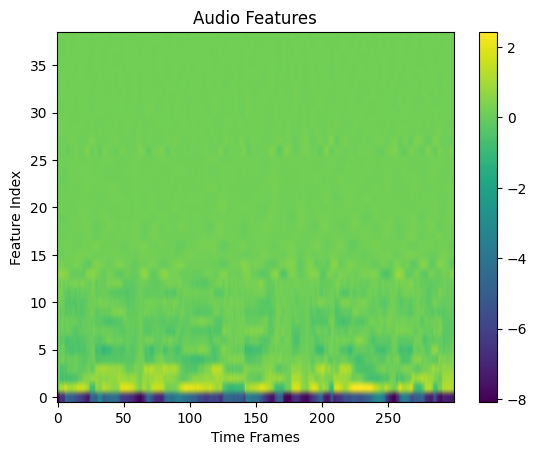

In [31]:
import matplotlib.pyplot as plt

plt.imshow(features, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Audio Features")
plt.xlabel("Time Frames")
plt.ylabel("Feature Index")
plt.show()


In [32]:
from IPython.display import Audio

Audio(filename="LJSpeech-1.1/wavs/LJ001-0001.wav")


In [33]:
import soundfile as sf

sf.write("processed_LJ001-0001.wav", y, sr)


In [34]:
from IPython.display import Audio

Audio(data=y, rate=sr)
